In [14]:
import pylab as pl
import numpy as np
import pandas as pd

from astropy.table import Table
import torch.autograd
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import *
import torch.nn.functional as F

import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import MultipleLocator

batch_size_val = 100
test_no = 1

class FeatureDataset(Dataset):
    def __init__(self,feature_file,label_file):
        self.features = np.array(pd.read_csv(feature_file))
        self.labels = np.array(pd.read_csv(label_file))      
        print("------读取文件结束------")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        feature = torch.Tensor(self.features[idx])
        label = torch.LongTensor(self.labels[idx])
        return feature,label

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(128,128),
            nn.PReLU(), 
            nn.Linear(128,128),
            nn.PReLU(),
            nn.Linear(128,4),
            nn.LogSoftmax()      
        )
    def forward(self, x):
        x = self.dense(x)
        return x

def val():
    print('start val')
    D.eval()
    label = []
    predict = []
    
    with torch.no_grad():
        for batch_idx, (_data,_label) in enumerate(val_loader):
            # print(batch_idx)
            _data = _data.cuda()
            _label = _label.cuda().view(-1)
            result = D(_data)
            result = result.cpu()
            _label = _label.cpu()
            for num in range(0,len(result)):
                predict.append(np.exp(result[num,:].numpy()))
                temp = np.zeros(4)
                temp[int(_label[num].numpy())] = 1
                label.append(temp)
        
    mat = np.array(label) 
    dataframe = pd.DataFrame(mat)
    dataframe.to_csv('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\label.csv'.format(test_no),index=False,sep=',')
    
    mat = np.array(predict) 
    dataframe = pd.DataFrame(mat)
    dataframe.to_csv('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\predict.csv'.format(test_no),index=False,sep=',')
    
    print('end val')

def ReadData(path,_sep = ',',_type = np.float32):
    #读取数据
    data = pd.read_csv(path,sep = _sep)
    npData = np.array(data).astype(_type)
    return npData

In [15]:
feature_dir = 'C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\'
label_dir = 'C:\\Users\\23650\\Desktop\\research\\NAO\\datasets\\'

valData = FeatureDataset(feature_dir + '{}\\feature_testSet.csv'.format(test_no),label_dir + 'testSet.csv')
val_loader = torch.utils.data.DataLoader(
    dataset=valData, batch_size=batch_size_val, shuffle=False
)

D = DNN().cuda() 
D.load_state_dict(torch.load('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\DNN-45.pth'.format(test_no)))
val()

------读取文件结束------
start val
end val


c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



In [16]:
#读取数据
trainLoss = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\train_losses.csv'.format(test_no))
testLoss = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\test_losses.csv'.format(test_no))
trainCounter = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\train_counter.csv'.format(test_no))
testCounter = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\test_counter.csv'.format(test_no))
trainAcc = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\train_acc.csv'.format(test_no))
testAcc = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\test_acc.csv'.format(test_no))

#预设的数据格式每行为1个样本属于各个类别的概率[x1,x2,x3,x4]
trueLabels = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\label.csv'.format(test_no))
predLabels = ReadData('C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\{}\\predict.csv'.format(test_no))

500
500


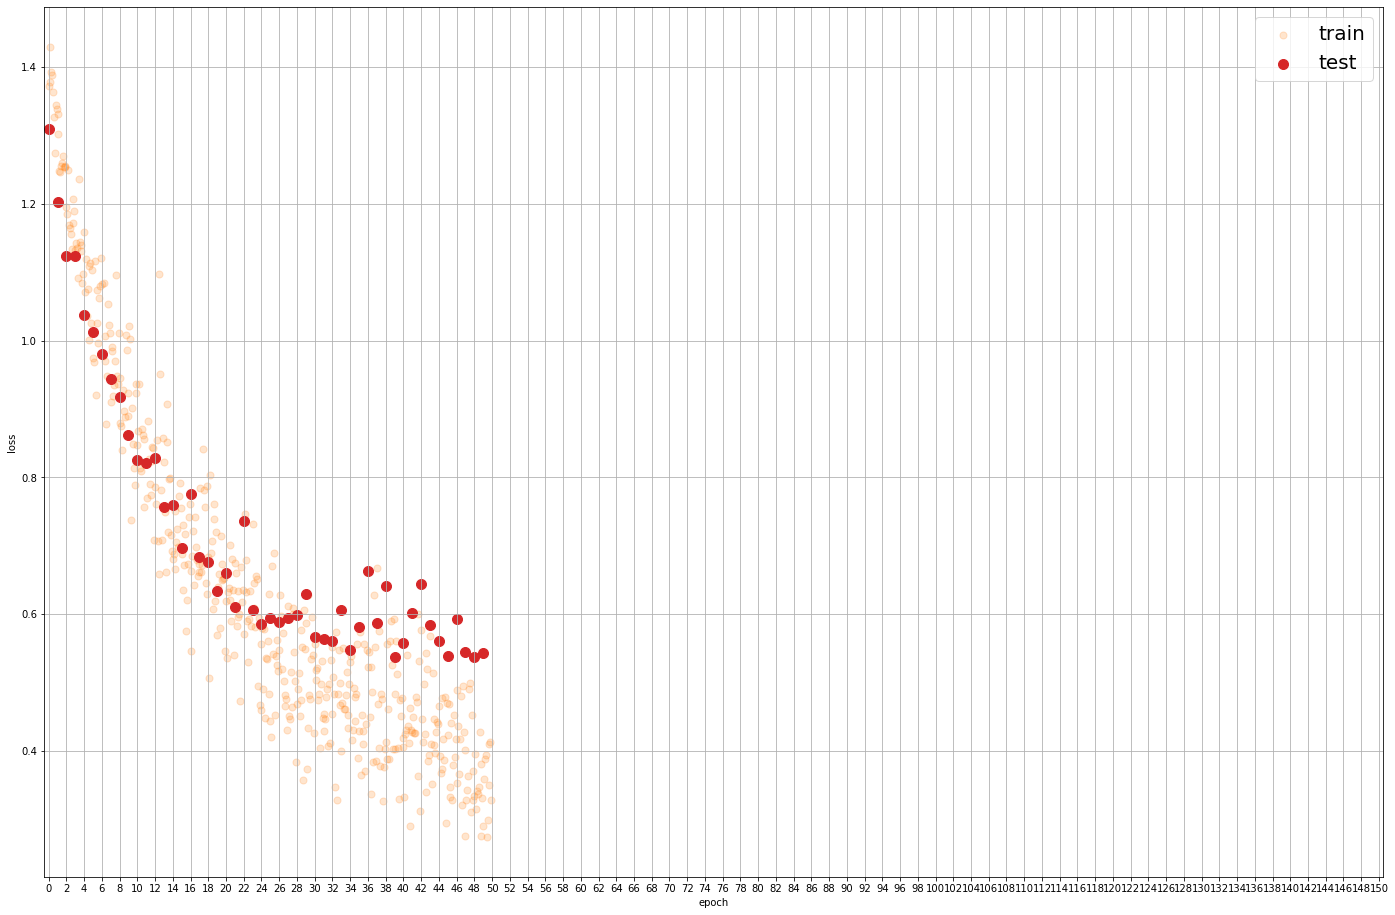

In [17]:
#绘制epoch-loss曲线
plt.figure(figsize=(24, 16))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([-0.5,150.5])
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.grid(True)
print(len(trainCounter))
print(len(trainLoss)) 
plt.scatter(trainCounter, trainLoss,s=50,c = 'C1',alpha = 0.2, label="train")
plt.scatter(testCounter, testLoss,s=100,c = 'C3', label="test")
#plt.yscale('log')
plt.legend(fontsize=20)
plt.savefig("loss.png")

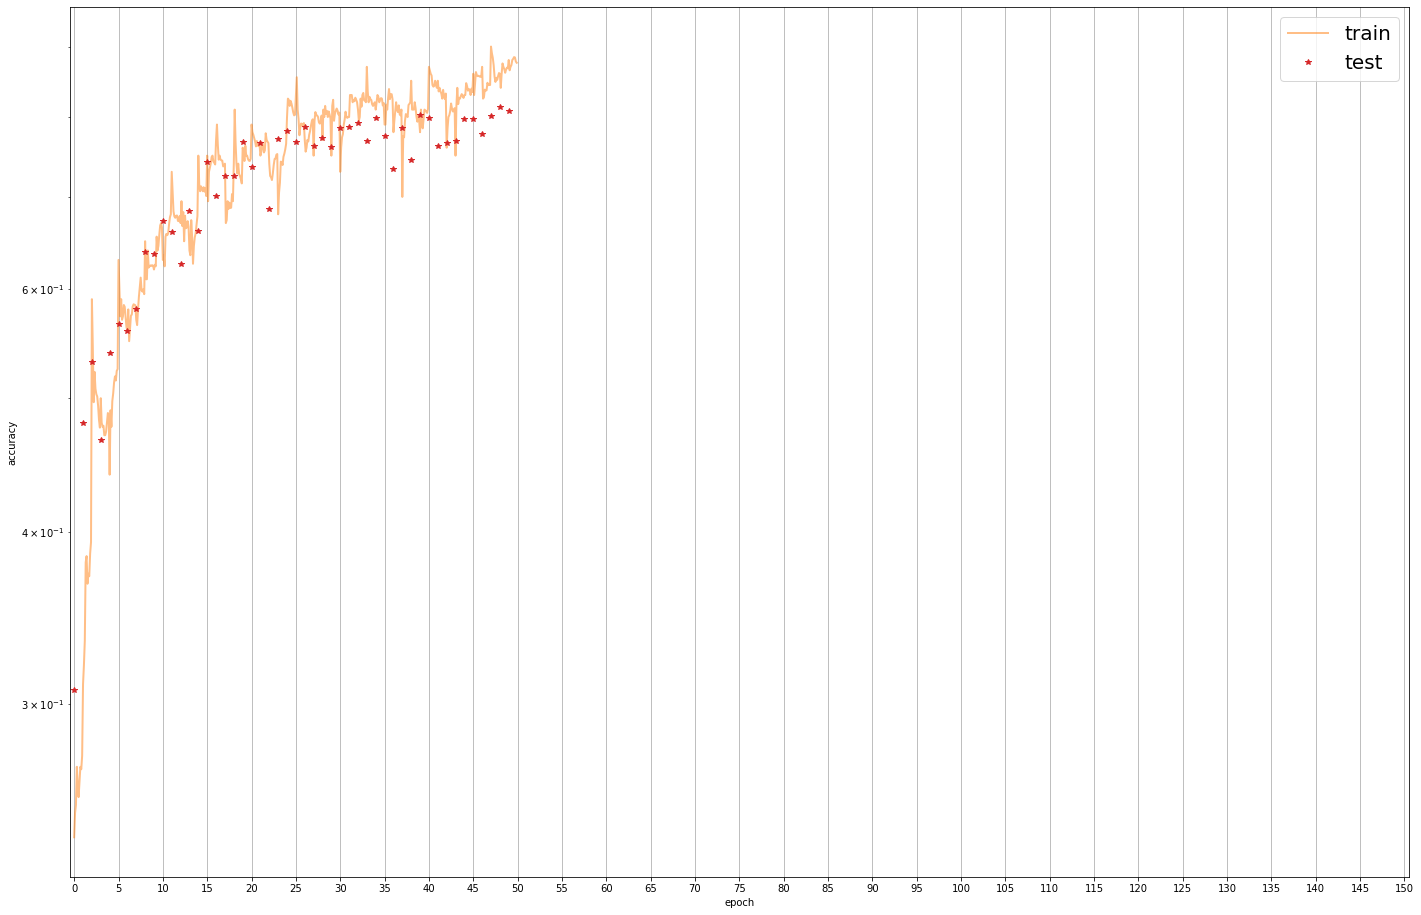

In [18]:
#绘制epoch-accuracy曲线
plt.figure(figsize=(24, 16))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([-0.5,150.5])
#plt.ylim([0.35,1.02])
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.grid(True)
plt.plot(trainCounter, trainAcc, 'C1-',alpha = 0.5, lw=2, label="train")
plt.plot(testCounter, testAcc, 'C3*', lw=4, label="test")
plt.yscale('log')
plt.legend(fontsize=20)
plt.savefig("accuracy.png")

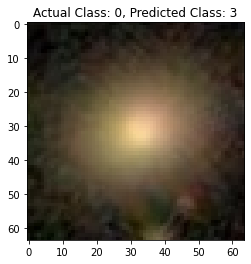

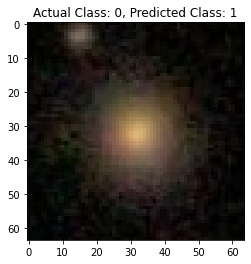

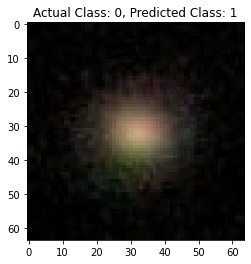

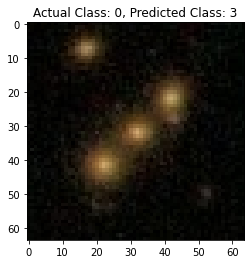

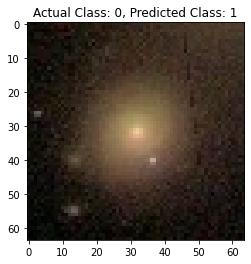

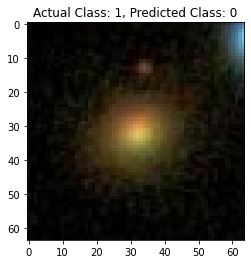

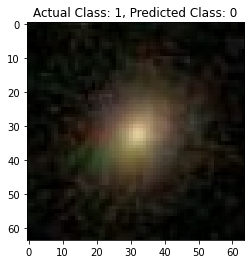

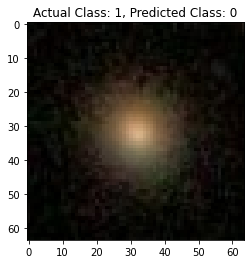

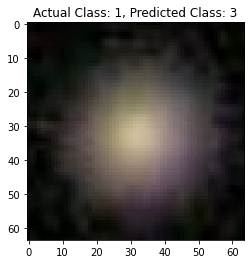

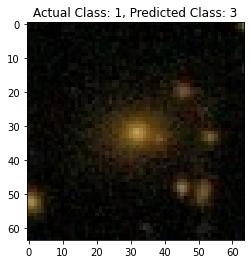

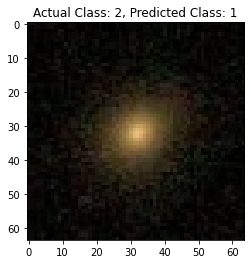

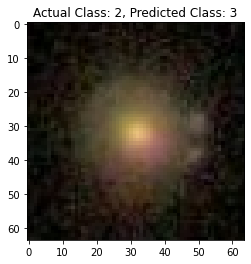

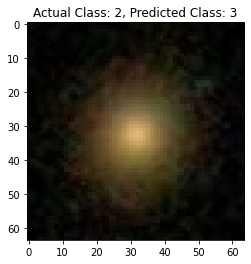

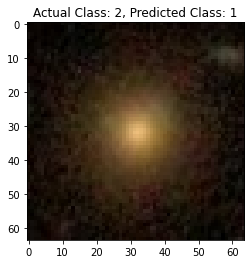

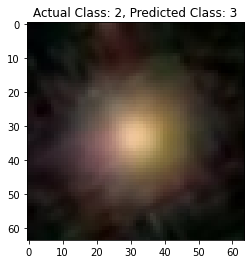

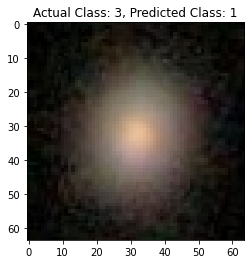

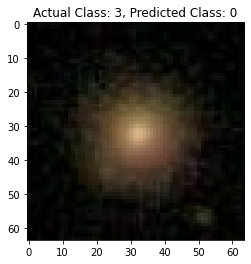

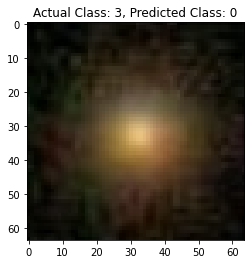

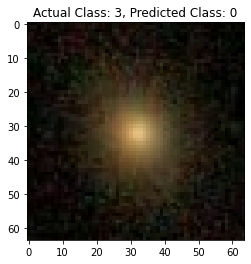

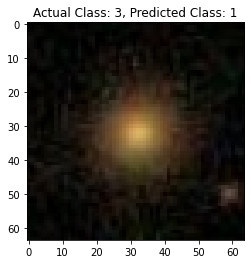

In [19]:
incorrect_indices = {}
for i in range(4):
    incorrect_indices[i] = []

for i, (label, prediction) in enumerate(zip(trueLabels, predLabels)):
    if np.argmax(label) != np.argmax(prediction):
        incorrect_indices[np.argmax(label)].append(i)
            
data = Table.read('C:\\Users\\23650\\Desktop\\research\\NAO\\datasets\\trainSet.hdf5',path="/data")
num_images_to_show = 5
for class_id, indices in incorrect_indices.items():
    for idx in indices[:num_images_to_show]:
        # Read the image data
        img_r = data['r'][idx] + 0.5
        img_g = data['g'][idx] + 0.5
        img_b = data['b'][idx] + 0.5

        # Combine the channels to form the image
        img = np.zeros([3, 64, 64])
        img[0, :, :] = img_r
        img[1, :, :] = img_g
        img[2, :, :] = img_b

        # Get the predicted class
        predicted_class = np.argmax(predLabels[idx])
        
        # Plot the image
        img = img.swapaxes(0, 1)
        img = img.swapaxes(1, 2)
        plt.imshow(img)
        plt.title(f'Actual Class: {class_id}, Predicted Class: {predicted_class}')
        plt.show()


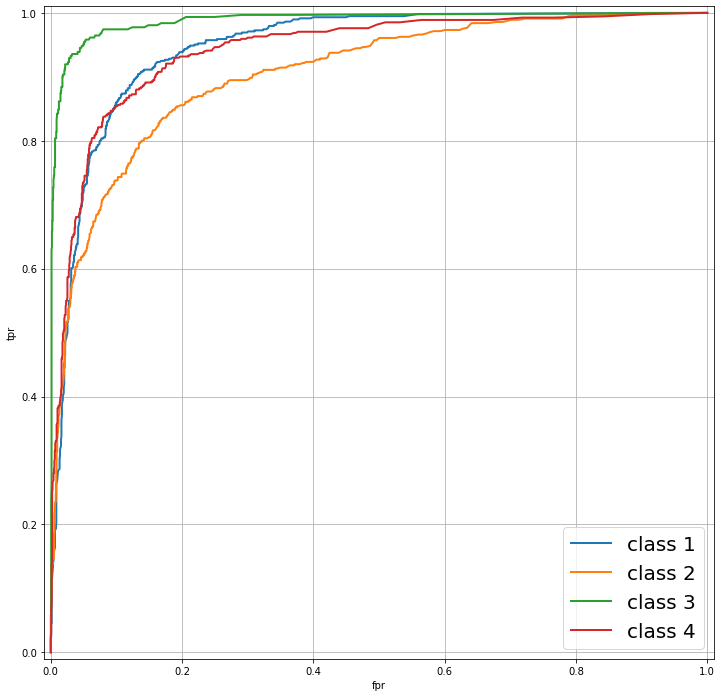

In [20]:
def FPR(data,label,idx,threshold):
    #指定阈值的假阳性率
    count = 0
    goal = 0
    for i in range(len(data)):
        if label[i][idx] < 0.5:
            count += 1
            if data[i][idx] > threshold:
                goal += 1
    return goal / count

def TPR(data,label,idx,threshold):
    #指定阈值的真阳性率
    count = 0
    goal = 0
    for i in range(len(data)):
        if label[i][idx] > 0.5:
            count += 1
            if data[i][idx] > threshold:
                goal += 1
    return goal / count

n = 1000
fprs0 = [FPR(predLabels,trueLabels,0,i/n) for i in range(n)]
tprs0 = [TPR(predLabels,trueLabels,0,i/n) for i in range(n)]
fprs1 = [FPR(predLabels,trueLabels,1,i/n) for i in range(n)]
tprs1 = [TPR(predLabels,trueLabels,1,i/n) for i in range(n)]
fprs2 = [FPR(predLabels,trueLabels,2,i/n) for i in range(n)]
tprs2 = [TPR(predLabels,trueLabels,2,i/n) for i in range(n)]
fprs3 = [FPR(predLabels,trueLabels,3,i/n) for i in range(n)]
tprs3 = [TPR(predLabels,trueLabels,3,i/n) for i in range(n)]

plt.figure(figsize=(12, 12))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
ax = plt.gca()
#ax.xaxis.set_major_locator(MultipleLocator(2))
ax.grid(True)
plt.plot(fprs0, tprs0, 'C0-', lw=2, label="class 1")
plt.plot(fprs1, tprs1, 'C1-', lw=2, label="class 2")
plt.plot(fprs2, tprs2, 'C2-', lw=2, label="class 3")
plt.plot(fprs3, tprs3, 'C3-', lw=2, label="class 4")
plt.legend(fontsize=20)
plt.savefig("ROC.png")

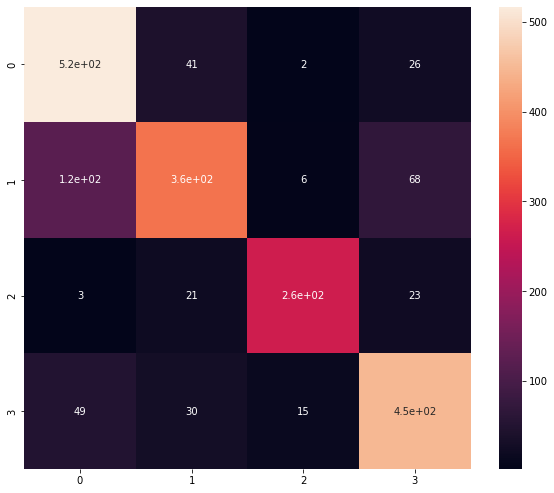

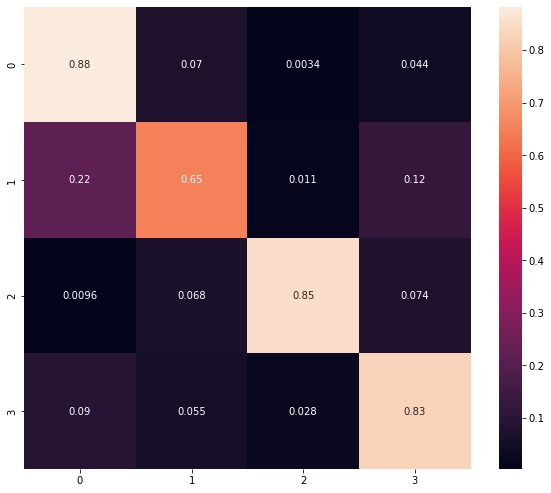

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['1','2','3','4']
trueLabelsArray = []
predLabelsArray = []
for i in range(len(trueLabels)):
    trueLabelsArray.append(trueLabels[i].argmax())
    predLabelsArray.append(predLabels[i].argmax())
    
plt.figure(figsize = (10,8.5))
sns.heatmap(metrics.confusion_matrix(y_true=trueLabelsArray, y_pred=predLabelsArray), annot=True);
plt.savefig("ConfusionMatrix.png")

plt.figure(figsize = (10,8.5))
sns.heatmap(metrics.confusion_matrix(y_true=trueLabelsArray, y_pred=predLabelsArray,normalize = 'true'), annot=True)
plt.savefig("ConfusionMatrix%.png")

------读取文件结束------


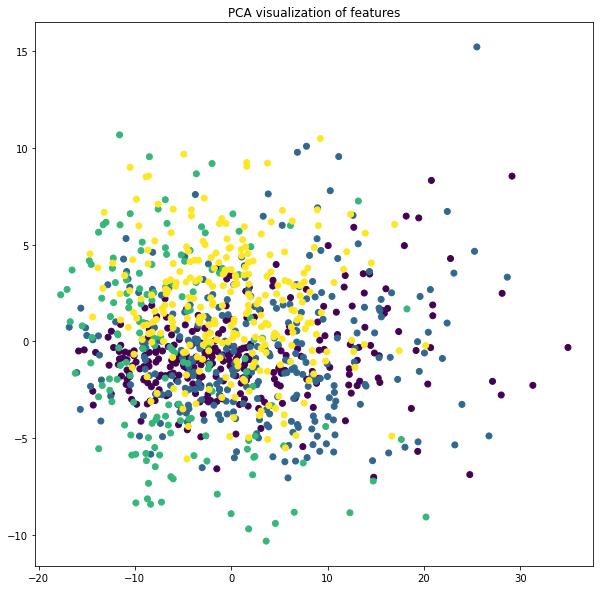

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.756081


c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.482933
[t-SNE] KL divergence after 1000 iterations: 1.324304


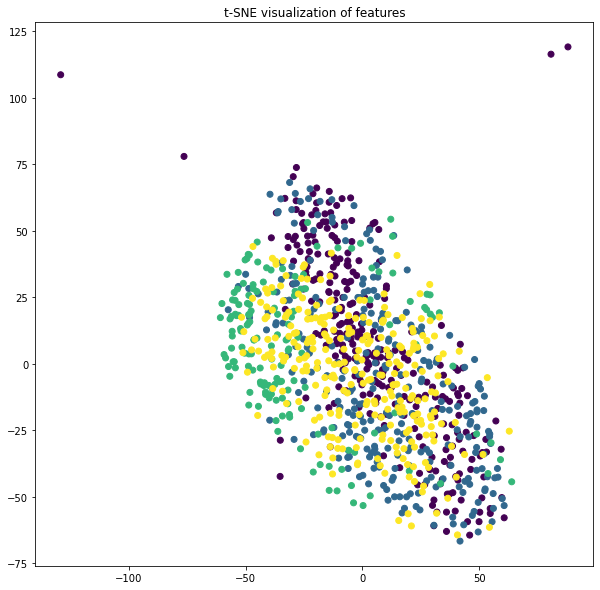

In [22]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class FeatureDataset(Dataset):
    def __init__(self,feature_file,label_file):
        self.features = np.array(pd.read_csv(feature_file))
        self.labels = np.array(pd.read_csv(label_file))      
        print("------读取文件结束------")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        feature = torch.Tensor(self.features[idx])
        label = torch.LongTensor(self.labels[idx])
        return feature,label

feature_dir = 'C:\\Users\\23650\\Desktop\\research\\NAO\\semi\\'
label_dir = 'C:\\Users\\23650\\Desktop\\research\\NAO\\datasets\\'
trainData = FeatureDataset(feature_dir + '{}\\feature_valSet.csv'.format(test_no),label_dir + 'valSet.csv')

labels = []
features = []

for feature,label in trainData:
        labels.append(label)
        features.append(feature)

# Convert the lists to numpy arrays
features = np.array([f.numpy() for f in features])
labels = np.array([l.item() for l in labels])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(10,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=labels)
plt.title('PCA visualization of features')
plt.show()

tsne = TSNE(n_components=3, verbose=1)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels)
plt.title('t-SNE visualization of features')
plt.show()

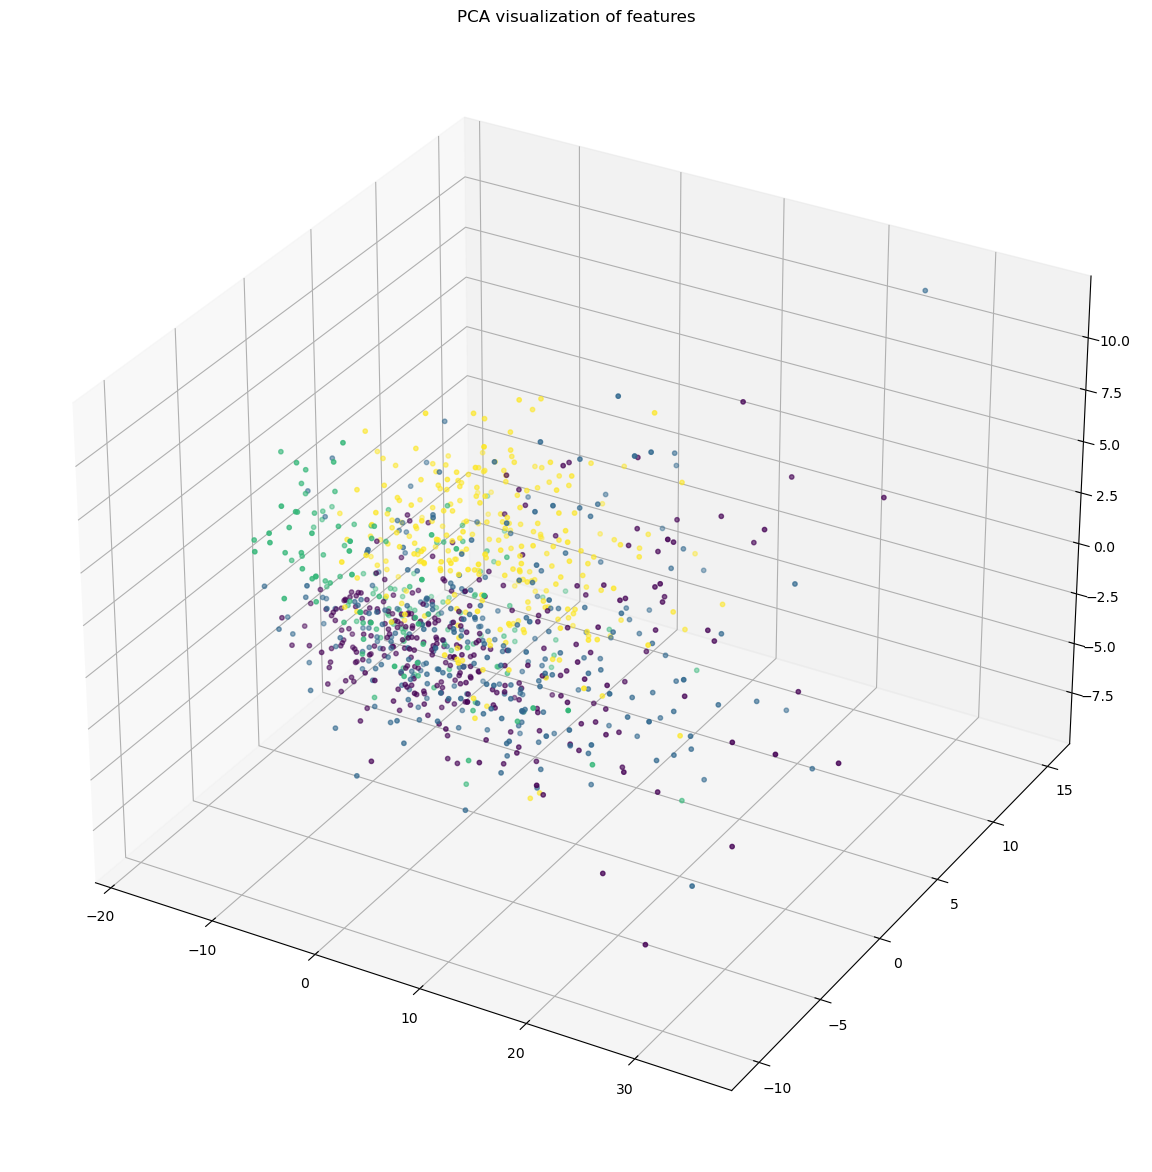

c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.756081
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.308998
[t-SNE] KL divergence after 1000 iterations: 1.217039


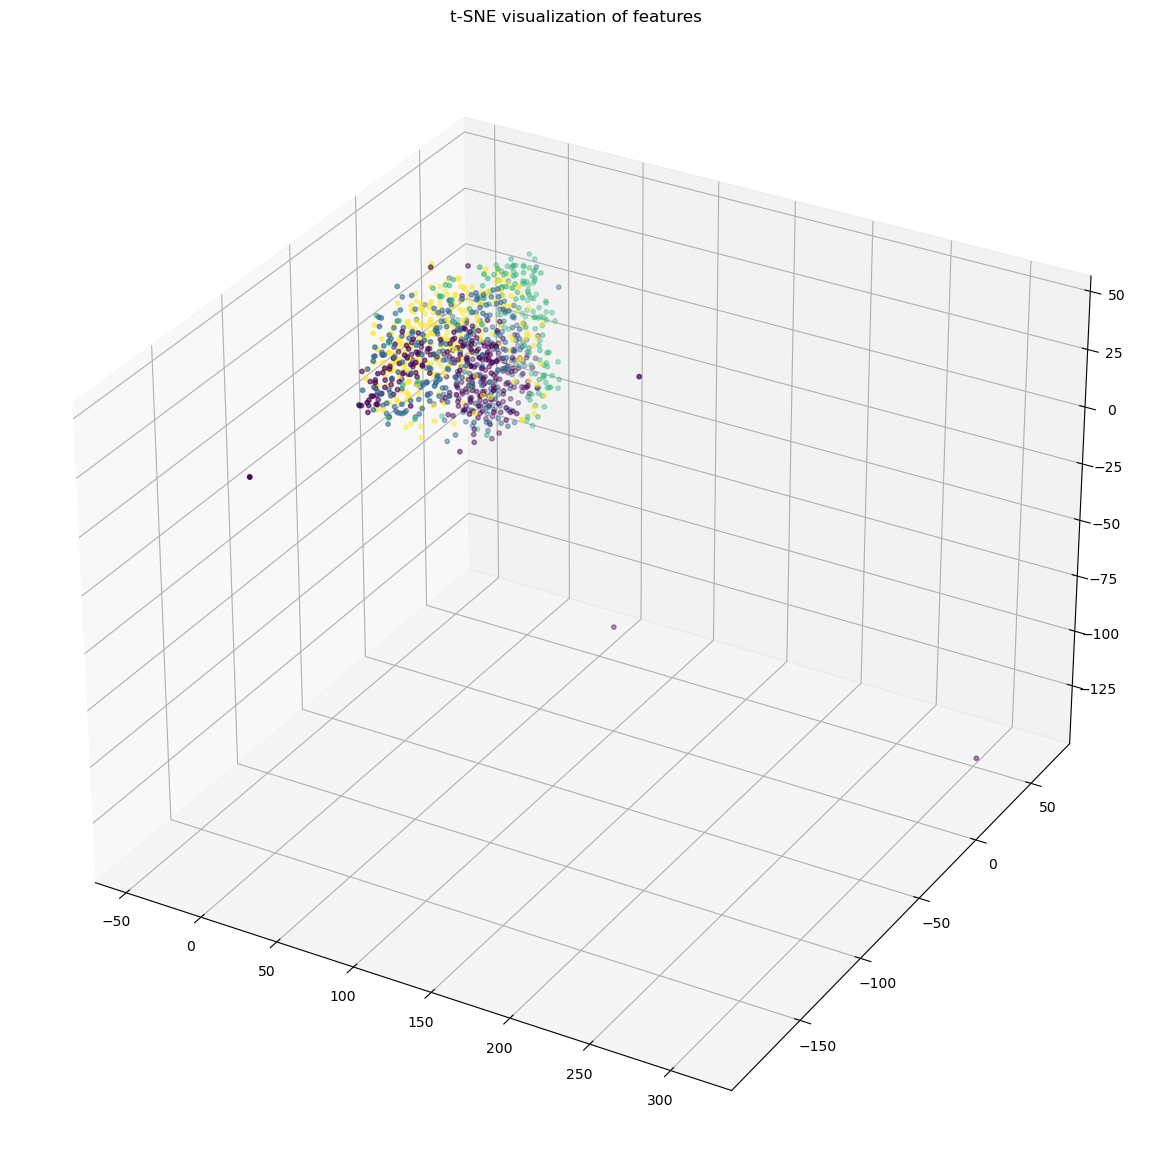

In [23]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

fig = plt.figure(figsize=(15, 15), dpi=100)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], c=labels, s=10) 
plt.title('PCA visualization of features')
plt.show()

tsne = TSNE(n_components=3, verbose=1)
tsne_results = tsne.fit_transform(features)

fig = plt.figure(figsize=(15, 15), dpi=100)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=labels, s=10)
plt.title('t-SNE visualization of features')
plt.show()


In [24]:
import plotly.graph_objects as go

pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

fig = go.Figure(data=[go.Scatter3d(
    x=pca_result[:,0],
    y=pca_result[:,1],
    z=pca_result[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,                
        colorscale='Viridis', 
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

import plotly.graph_objects as go
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(features)

fig = go.Figure(data=[go.Scatter3d(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    z=tsne_results[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,              
        colorscale='Viridis', 
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

